In [1]:
import pandas as pd
import numpy as np
import os

chloe_df_limited = pd.read_csv(r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks\participant features\chloe_limited.csv')
libing_df = pd.read_csv(r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks\participant features\libing.csv')
wenjian_df = pd.read_csv(r'C:\Users\chloe\OneDrive\Desktop\swallow EMG\notebooks\participant features\wenjian.csv')

chloe_df_limited = chloe_df_limited.dropna()
libing_df =libing_df.dropna()
wenjian_df = wenjian_df.dropna()

In [2]:
os.chdir("..") 
from src import feature_extraction, models, utils
from src.models import multioutput_models

chloe_x = chloe_df_limited.drop(columns=['volume', 'substance'])
chloe_y = chloe_df_limited[['substance', 'volume']]

chloe_x_train, chloe_x_test, chloe_y_train, chloe_y_test = models.make_split(chloe_x, chloe_y, 42)

libing_x = libing_df.drop(columns=['volume', 'substance'])
libing_y = libing_df[['substance', 'volume']]

libing_x_train, libing_x_test, libing_y_train, libing_y_test = models.make_split(libing_x, libing_y, 42)

wenjian_x = wenjian_df.drop(columns=['volume', 'substance'])
wenjian_y = wenjian_df[['substance', 'volume']]

wenjian_x_train, wenjian_x_test, wenjian_y_train, wenjian_y_test = models.make_split(wenjian_x, wenjian_y, 42)

In [3]:
from sklearn.base import clone

def train_and_save_models(x_train, x_test, y_train, y_test):
    acc = []
    per_label_acc = []

    models_copy = [[name, clone(model)] for name, model in multioutput_models]

    for model in models_copy:
        model[1].fit(x_train, y_train)
        y_pred = model[1].predict(x_test)

        # Exact match accuracy (all labels correct)
        exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

        # Per-label accuracy
        per_label_accuracy = (y_test == y_pred).mean(axis=0)

        acc.append(exact_match_accuracy * 100)
        per_label_acc.append(per_label_accuracy * 100)

    models.print_metrics(acc, per_label_acc)

    return acc, per_label_acc, models_copy

def holdout_validation(x_test, y_test, models):
    acc = []
    per_label_acc = []

    for model in models:
        y_pred = model[1].predict(x_test)

        # Exact match accuracy (all labels correct)
        exact_match_accuracy = np.mean(np.all(y_test.values == y_pred, axis=1))

        # Per-label accuracy
        per_label_accuracy = (y_test == y_pred).mean(axis=0)

        acc.append(exact_match_accuracy * 100)
        per_label_acc.append(per_label_accuracy * 100)

    return acc, per_label_acc

In [4]:
chloe_acc, chloe_label_acc, chloe_models = train_and_save_models(chloe_x_train, chloe_x_test, chloe_y_train, chloe_y_test)

SVM
Exact Match Accuracy: 62.5000
Per-Label Accuracies: [75.  87.5]
----------------------------
KNN
Exact Match Accuracy: 50.0000
Per-Label Accuracies: [62.5 87.5]
----------------------------
Decision Tree
Exact Match Accuracy: 75.0000
Per-Label Accuracies: [87.5 87.5]
----------------------------
Naive Bayes
Exact Match Accuracy: 62.5000
Per-Label Accuracies: [87.5 75. ]
----------------------------
Logistic Regression
Exact Match Accuracy: 75.0000
Per-Label Accuracies: [87.5 87.5]
----------------------------
Gradient Boost
Exact Match Accuracy: 100.0000
Per-Label Accuracies: [100. 100.]
----------------------------


In [5]:
libing_acc, libing_label_acc = holdout_validation(libing_x_test, libing_y_test, chloe_models)

In [6]:
wenjian_acc, wenjian_label_acc = holdout_validation(wenjian_x_test, wenjian_y_test, chloe_models)

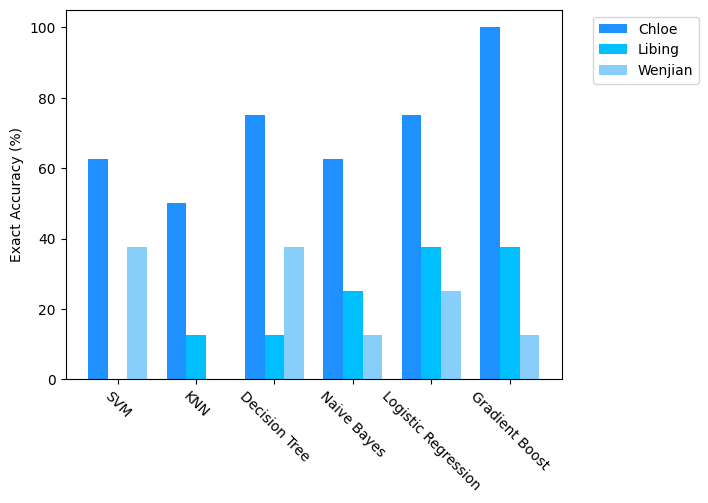

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(multioutput_models))  # [0, 1, 2]
width = 0.25  # width of each bar

# Plot bars side by side
plt.bar(x - width, chloe_acc, width, label='Chloe', color='dodgerblue')
plt.bar(x, libing_acc, width, label='Libing', color='deepskyblue')
plt.bar(x + width, wenjian_acc, width, label='Wenjian', color='lightskyblue')

# Add labels
model_names = [name for name, _ in multioutput_models]

plt.xticks(x, model_names, rotation=-45)
plt.ylabel('Exact Accuracy (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()